In [4]:
import household_contact_tracing.branching_process_models as bpm
from household_contact_tracing.branching_process_controller import BranchingProcessController
from copy import copy

# Notebook purpose
To provide minimal working examples of various model functionalities for the IndividualLevelDailyContactTesting.

# Individual-level contact tracing, with daily contact testing
We now extend the individual level contact tracing process with daily contact testing. The idea is that instead of traced contacts quarantining, they will instead test themselves daily using lateral flow tests. This can allow for higher levels of adherence, since the contact tracing process is less burdensome. In addition, this will allow for the detection of asymptomatic chains of transmission and potentially detecting cases earlier in their infection. Household contacts are a special case, and we consider several different household contact policies. We also include models of how test sensitivity varies over time, for both lateral flow and pcr tests.

## Baseline parameters

In [5]:
# define some easy to look at test sensitivity functions
def prob_testing_positive_function_pcr(time_relative_to_symptom_onset):
    # Prevents people testing positive as soon as they get it
    if time_relative_to_symptom_onset in [4, 5, 6]:
        return 0.75
    else:
        return 0

def prob_testing_positive_function_lfa(time_relative_to_symptom_onset):
    # Prevents people testing positive as soon as they get it
    if time_relative_to_symptom_onset in [4, 5, 6]:
        return 0 # this is unrealistic, but it makes it easier to see nodes being lfa tested since they wont move to the isolation status due to lfa testing
    else:
        return 0

In [6]:
params = {"outside_household_infectivity_scaling": 0.3,
                  "contact_tracing_success_prob": 0.7,
                  "overdispersion": 0.32,
                  "asymptomatic_prob": 0.2,
                  "asymptomatic_relative_infectivity": 0.35,
                  "infection_reporting_prob": 0.5,
                  "LFA_testing_requires_confirmatory_PCR": False,
                  "reduce_contacts_by": 0.5,
                  "test_delay": 1,
                  "contact_trace_delay": 1,
                  "incubation_period_delay": 5,
                  "symptom_reporting_delay": 1,
                  "starting_infections": 5,
                  "household_pairwise_survival_prob": 0.2,
                  "self_isolation_duration": 10,
                  "lateral_flow_testing_duration": 14,
                  "propensity_risky_behaviour_lfa_testing": 0,
                  "global_contact_reduction_risky_behaviour": 0,
                  "household_positive_policy": "lfa_testing_no_quarantine"
                  }

# Household contact policy 1:
Household contact quarantine as per the current policy, and are not lateral flow tested. Only those traced via a between household contact tracing attempt should be lateral flow tested, if they are not isolating.

In [7]:
model = bpm.IndividualTracingDailyTesting(params)
model.prob_lfa_positive = prob_testing_positive_function_lfa
model.prob_pcr_positive = prob_testing_positive_function_pcr
controller = BranchingProcessController(model)

INFO - Added final run results to file: /home/ann/Code/TTI/TestingContactModel/temp/simulation_output_20210714.csv


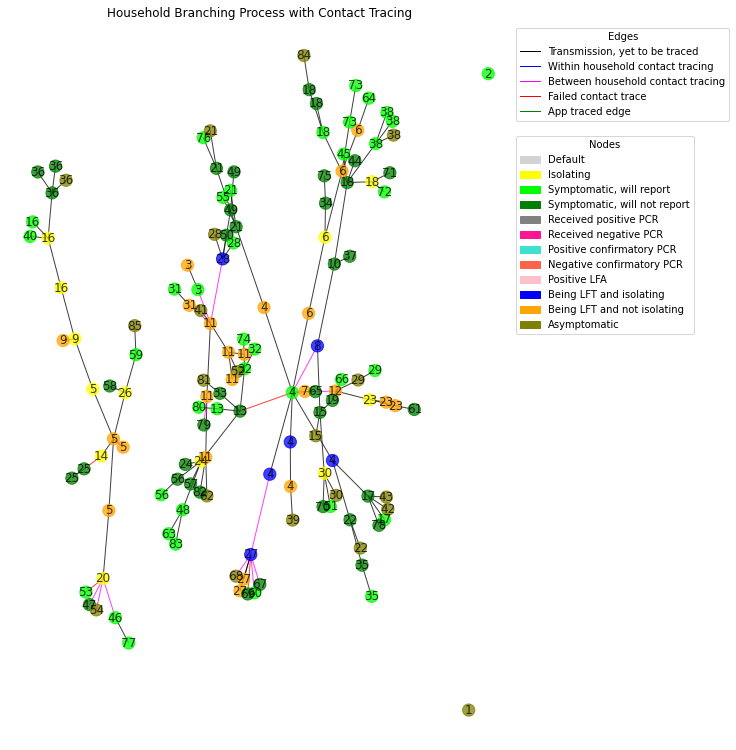

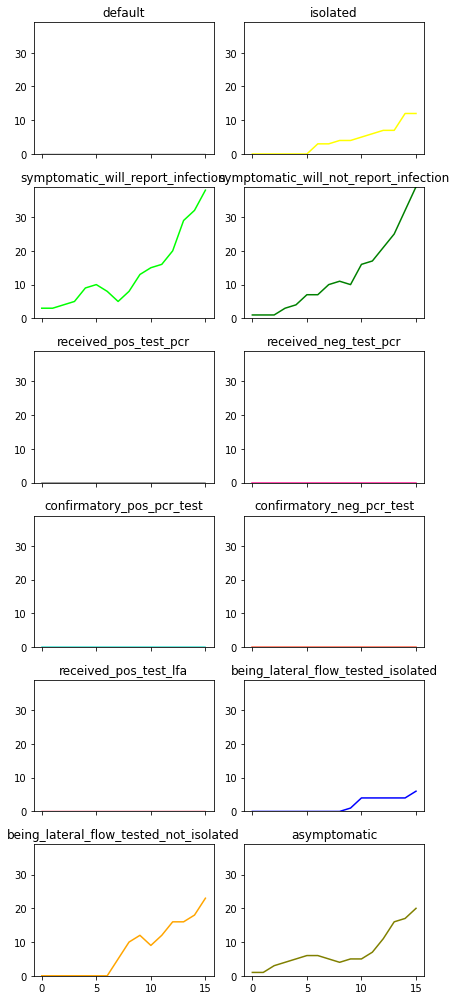

In [8]:
controller.graph_view.set_display(True)
controller.timeline_view.set_display(True)
controller.run_simulation(16)

Note: The blue nodes were surprising to me here, I think these are where an individual was traced, so they started taking lateral flow tests, and then they started isolating because a household member had symptom onset, or because they tested positive and haven't stopped LFA testing for some reason. It's not necessarily wrong, but something I need to double check.

Checklist:
* In addition to the usual contact tracing status', you should now see some of the LFA testing node status' appearing
* 'Being LFT and isolating' (blue) might start appearing, I think this is correct/fine for now, I may want to correct in the future
* 'Being LFT and not isolating' (orange) is our daily contact testing status, you should see some of these. Individuals reached by an out-of-household contact tracing attempt should have this status, as they are being daily contact tested and do not need to isolate

# Household contact policy 2:
Previously, household contacts were only isolating. Now, household contacts will isolate AND take lateral flow tests. This would allow us to trace housheold member contacts if they made infectious contacts shortly before the household was quarantined.

In [ ]:
params_policy_2 = copy(params)
params_policy_2['household_positive_policy'] = "lfa_testing_and_quarantine"

In [ ]:
model = bpm.IndividualTracingDailyTesting(params_policy_2)
model.intervention.prob_testing_positive_lfa_func = prob_testing_positive_function_lfa
model.intervention.prob_testing_positive_pcr_func = prob_testing_positive_function_pcr
controller.model = model

In [ ]:
controller.run_simulation(16)

Checklist:
* You should still see some "Being LFT and not isolating" (orange) nodes, who were out-of-household contacts that were traced and are being daily contact tested.
* Nearly entire households should have the "Being LFT and isolating status" (dark blue). This is due to the new policy here household contacts are being lfa tested.
* Some nodes may have the yellow status, this means their lateral flow testing duration is over, but they still need to self-isolate (this doesn't make sense in practice, but is due to some model parameters)

# Household contact policy 3:
Household contacts do not need to quarantine, but are lateral flow tested.

In [ ]:
params_policy_3 = copy(params)
params_policy_3['household_positive_policy'] = "lfa_testing_no_quarantine"

In [ ]:
model = bpm.IndividualTracingDailyTesting(params_policy_3)
model.prob_testing_positive_lfa_func = prob_testing_positive_function_lfa
model.prob_testing_positive_pcr_func = prob_testing_positive_function_pcr
controller.model = model

In [ ]:
controller.graph_pyvis_view.set_display(True)
controller.graph_pyvis_view.open_in_browser = True
controller.run_simulation(16)

Checklist:
* You should see a lof of "Being LFT and not isolating" (orange) nodes, as this will include within-household contacts and out-of-household contacts
* There are rare exceptions where you might see a "Being LFT and isolating" (blue) status, but I don't think is an issue
* Some nodes may have the yellow status, this means their lateral flow testing duration is over, but they still need to self-isolate (this doesn't make sense in practice, but is due to some model parameters)

The rest of the parameters will be very hard to see on the network plots, as they mostly just affect background probabilities. They will probably be better tested via unit tests, or by some other test method

In [ ]:
controller.graph_view.set_display(True)
controller.timeline_view.set_display(True)
controller.run_simulation(20)